In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'
import numpy as np
import scipy as sp
import scipy.integrate
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from spectral import *
np.set_printoptions(linewidth=120)

In [2]:
L, Hy = 80, 50  # mm
nx, ny = 16, 10
mesh_x = Multidomain(Legendre(20), np.linspace(0, L, nx + 1))
mesh_y = Multidomain(Legendre(20), np.linspace(-Hy/2, Hy/2, ny + 1), periodic=True)
mesh_z = Constant()
mesh = mesh_x*mesh_y*mesh_z

rho = 1.18; young = 4; nu = 0.34 # PMMA, GPa
#rho = 8.4; young = 110; nu = 0.34 # brass, GPa

lam = young*nu/(1 + nu)/(1 - 2*nu)
mu = young/2/(1 + nu)

rho_water = 1.0; lam_water = 2.2; mu_water = 0.0 # water
mask = np.zeros(mesh.shape, bool)
Nx, Ny, Nz = mesh.shape
mask.reshape(nx, Nx//nx, ny, Ny//ny)[2:,:,4:6,:] = True
rho = TensorField(mesh, rho*mask + rho_water*~mask)
lam = TensorField(mesh, lam*mask + lam_water*~mask)
mu = TensorField(mesh, mu*mask + mu_water*~mask)

impact_width = 3

In [3]:
def kin_energy(v):
    return (rho*v@v).int()/2

def pot_energy(u):
    deform = u.grad()
    CG = 1/2*(deform + deform.T)
    I1 = CG.trace()
    I2 = 1/2*(CG.trace()**2 - (CG@CG.T).trace())
    pot = (lam/2 + mu)*I1**2 - 2*mu*I2
    return pot.int()

def energy(u, v):
    return kin_energy(v) + pot_energy(u)

In [4]:
def compress(u, v):
    return np.stack((u.func, v.func)).ravel()

def decompress(y):
    func_u, func_v = y.reshape(2, 3, *mesh.shape)
    u = TensorField(mesh, func_u)
    v = TensorField(mesh, func_v)
    return u, v

def derivative(t, y):
    u, v = decompress(y)
    ut = v
    
    deform = u.grad()
    CG = 1/2*(deform + deform.T)
    I1 = CG.trace()
    dI1 = np.eye(3)
    dI2 = dI1*CG.trace() - CG
    PK = (lam + 2*mu)*I1*dI1 - 2*mu*dI2
    
    bval = (f(t), 0), (0, 0), (0, 0)
    F = PK.div(bval)
    F = F.match_domains()
    
    F += F_external(t)
    
    vt = F/rho
    return compress(ut, vt)

In [5]:
def f(t):
    return 0
matrix_size = 2*3*np.prod(mesh.shape)
print(matrix_size)
if matrix_size <= 3000:
    A = np.zeros((matrix_size, matrix_size))
    for i, y in enumerate(Progress(np.eye(matrix_size))):
        A[:,i] = derivative(0, y)
    e = np.linalg.eigvals(A)
    print(np.abs(e.real).max())
    print(np.abs(e.imag).max())

384000


In [6]:
plt.plot(np.abs(e.real), np.abs(e.imag), '.')
plt.yscale('log')
plt.xscale('log')

NameError: name 'e' is not defined

In [14]:
np.sum(np.abs(e.real) > 1e-10)

NameError: name 'e' is not defined

# Boundary impact

In [9]:
F = np.zeros((3, Ny, 1))
F[0] = 1e0*np.exp(-t**2/2/tau**2 - grid_y**2/2/impact_width**2)[:, None]

In [10]:
np.exp(-t**2/2/tau**2 - grid_y**2/2/impact_width**2).shape

(200,)

In [7]:
#%%time
tau = 0.20  # us
t0 = -8*tau
t_max = 40.0
dt = 0.1
T = np.arange(t0, t_max + dt/2, dt)
u0 = TensorField(mesh, np.zeros((3,) + mesh.shape))
v0 = TensorField(mesh, np.zeros((3,) + mesh.shape))

U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
E = np.zeros(len(T))

grid_x, grid_y, grid_z = mesh.grid()

def f(t):
    F = np.zeros((3, Ny, 1))
    F[0] = 1e0*np.exp(-t**2/2/tau**2 - grid_y**2/2/impact_width**2)[:, None]
    return F

def F_external(t):
    return 0

r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

KeyboardInterrupt: 

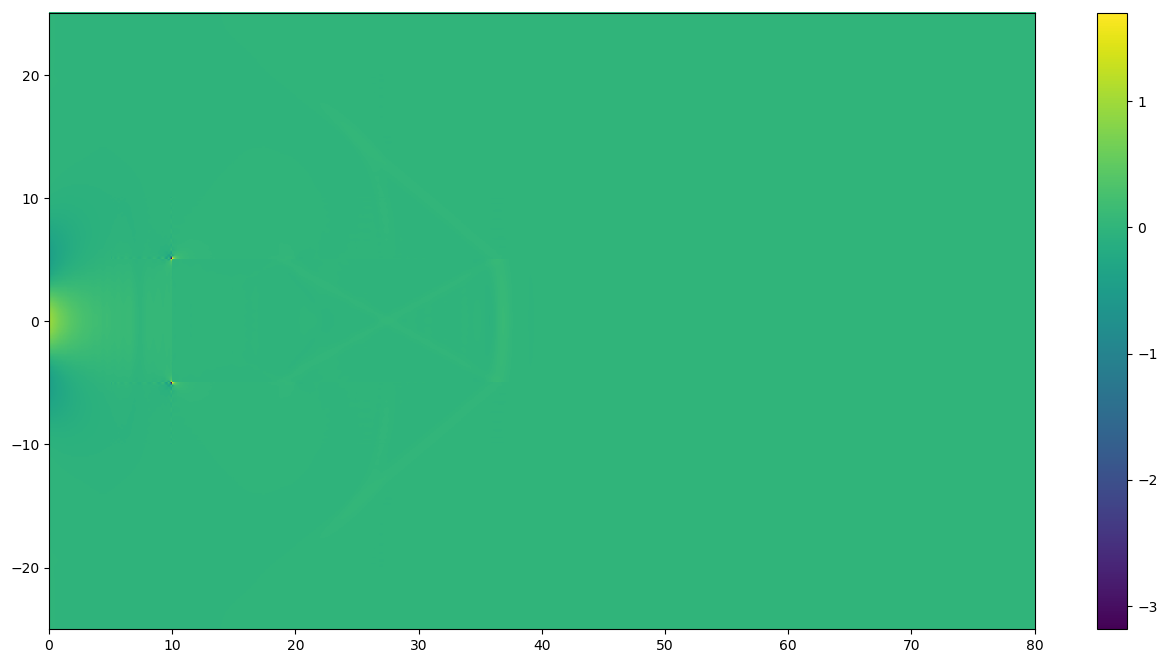

In [16]:
plt.figure(figsize=(16, 8))
k = 200
u = -U[k, 0](None, None, 0).diff(0)
x = np.linspace(0, L, 1000)
y = np.linspace(-Hy/2, Hy/2, 500)
heatmap(x, y, u(x, y))
plt.colorbar()
plt.gca().set_aspect('equal')

HTML(value='')

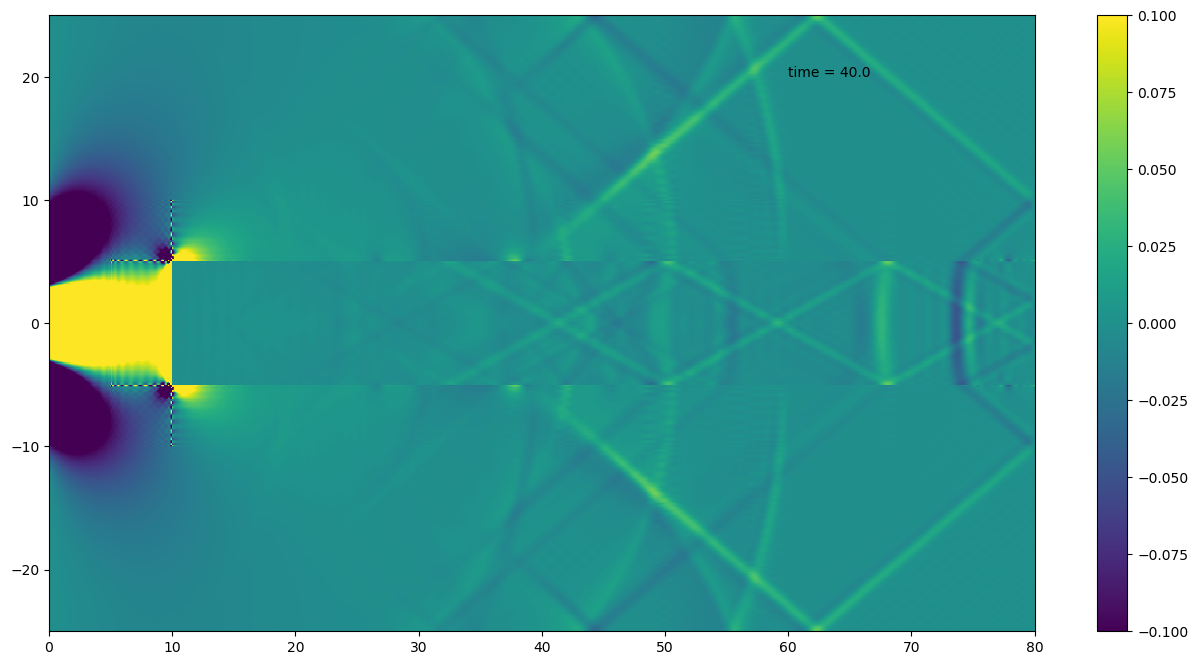

In [17]:
fig = plt.figure(figsize=(16, 8))
x = np.linspace(0, L, 1000)
y = np.linspace(-Hy/2, Hy/2, 500)
im = plt.imshow(np.zeros((len(x), len(y))), animated=True, 
                extent=(x.min(), x.max(), y.min(), y.max()))
plt.colorbar()
ax = plt.gca()
ax.set_aspect('equal')

time_template = 'time = %.1f'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)

p = Progress(len(T))

def animate(k):
    p.update()
    u = -U[k, 0](None, None, 0).diff(0)
    im.set_data(u(x, y).T)
    time_text.set_text(time_template % T[k])
    return im, time_text

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(T), interval=50, blit=True)

anim

In [48]:
anim.save('water_impact.mp4', fps=30, dpi=100)

In [9]:
fig, ax = plt.subplots()
plt.xlim(0, L)
plt.ylim(-0.5e-0, 1e-0)
line, = ax.plot([], [])
time_template = 'time = %.1f'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)
plt.xlabel(r'$x$')
plt.ylabel(r'$U_x(x, 0, 0)$')
plt.close()

def animate(k):
    u = -U[k, 0](None, 0, 0).diff()
    x = np.linspace(0, L, 300)
    line.set_data(x, u(x))
    time_text.set_text(time_template % T[k])
    return line, time_text

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(T), interval=50, blit=True)

anim

In [19]:
#anim.save('animation.gif', writer='imagemagick', fps=30)
anim.save('animation_lin.mp4', fps=30, dpi=100)

# Internal impact 

In [46]:
#%%time
tau = 0.20  # us
w = 0.5
x0 = L/nx
t0 = -8*tau
t_max = 40.0
dt = 0.1
T = np.arange(t0, t_max + dt/2, dt)
u0 = TensorField(mesh, np.zeros((3,) + mesh.shape))
v0 = TensorField(mesh, np.zeros((3,) + mesh.shape))

U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
E = np.zeros(len(T))

X, Y, Z = np.meshgrid(*mesh.grid(), indexing='ij')

def f(t):
    return 0

def F_external(t):
    data = np.zeros((3, *mesh.shape))
    data[0] = (X - x0)*np.exp(-t**2/2/tau**2 - (X - x0)**2/2/w**2  - Y**2/2/impact_width**2)
    return TensorField(mesh, data)

r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

In [ ]:
F_external(0)(x, y)

In [ ]:
x0

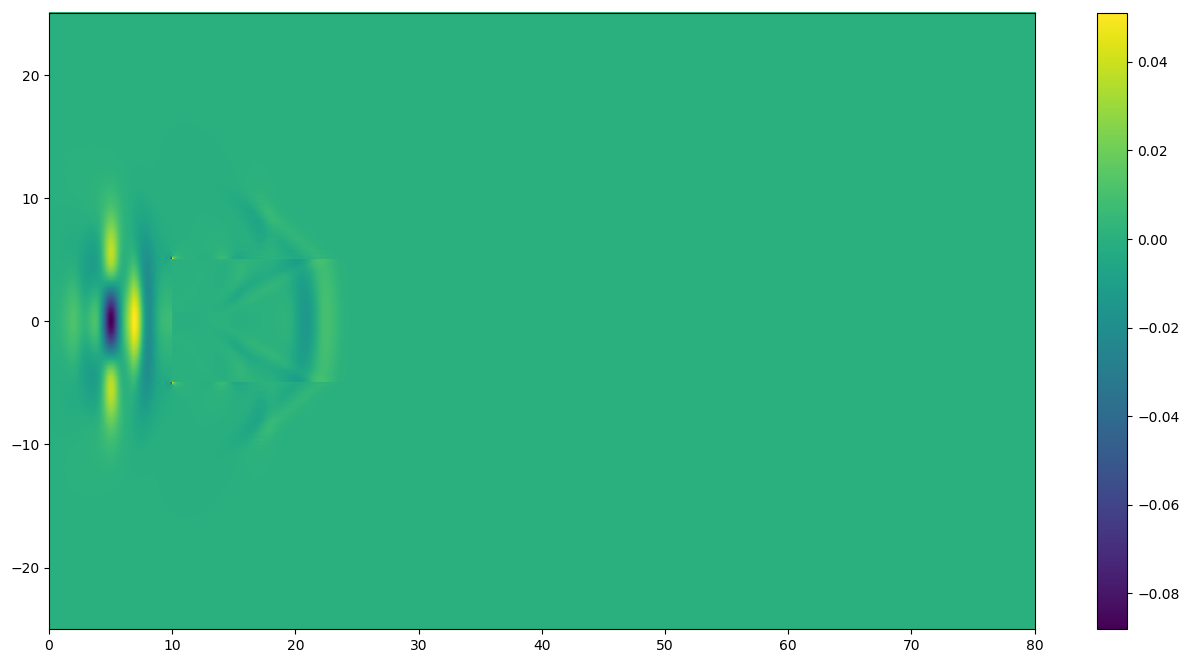

In [49]:
plt.figure(figsize=(16, 8))
k = 100
u = -U[k, 0](None, None, 0).diff(0)
x = np.linspace(0, L, 1000)
y = np.linspace(-Hy/2, Hy/2, 500)
heatmap(x, y, u(x, y))
plt.colorbar()
plt.gca().set_aspect('equal')

HTML(value='')

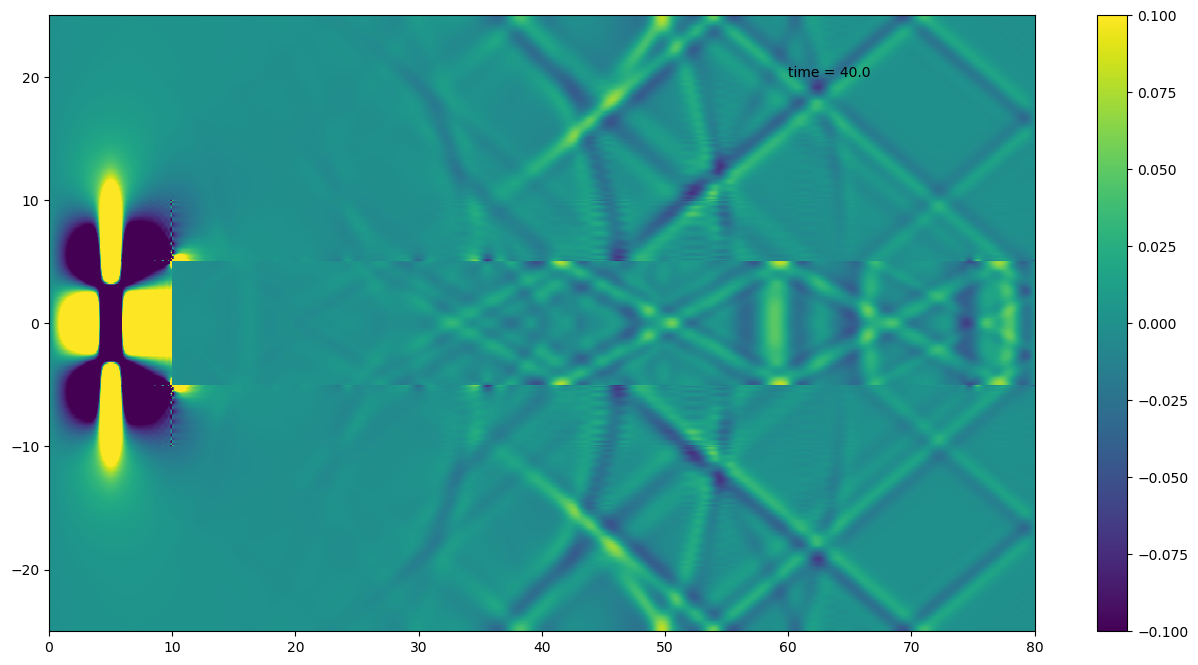

In [51]:
fig = plt.figure(figsize=(16, 8))
x = np.linspace(0, L, 1000)
y = np.linspace(-Hy/2, Hy/2, 500)
im = plt.imshow(np.zeros((len(x), len(y))), animated=True, 
                extent=(x.min(), x.max(), y.min(), y.max()))
plt.colorbar()
ax = plt.gca()
ax.set_aspect('equal')

time_template = 'time = %.1f'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)

p = Progress(len(T))

def animate(k):
    p.update()
    u = -10*U[k, 0](None, None, 0).diff(0)
    im.set_data(u(x, y).T)
    time_text.set_text(time_template % T[k])
    return im, time_text

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(T), interval=50, blit=True)

anim

In [22]:
np.sort(np.linalg.eigvals(A).real)

array([-0.00766504, -0.00766504, -0.00766504, ...,  0.00766504,  0.00766504,  0.00766504])

In [10]:
e, v = np.linalg.eig(A)
omega = e.imag
sorting = np.argsort(omega)
sorting = sorting[omega[sorting] > 1e-7]
omega = omega[sorting]
frequency = omega/2/np.pi*1e6
eigvec = v[:,sorting]

In [11]:
frequency[:15]

array([2.41270998e-02, 3.12746494e-02, 3.70974148e-02, 3.70974206e-02, 4.79073214e+02, 5.19039118e+02, 8.06608253e+02,
       9.28394696e+02, 1.31395807e+03, 1.42277100e+03, 2.19115062e+03, 2.51435057e+03, 2.55728318e+03, 2.76632169e+03,
       4.02832867e+03])

In [138]:
# workaround, see https://github.com/enthought/mayavi/issues/503
import sys
stream = sys.stdout 

from mayavi import mlab
mlab.init_notebook('x3d', width=500, height=300)
mlab.options.offscreen = True
from tvtk.api import tvtk
from mayavi.sources.vtk_data_source import VTKDataSource

# workaround, see https://github.com/enthought/mayavi/issues/503
sys.stdout = stream

def mesh(u, scale=1, d=2.5, sub=3):
    (x_min, y_min, z_min), (x_max, y_max, z_max) = u.X1, u.X2
    x = np.linspace(x_min, x_max, sub*round((x_max - x_min)/d) + 1)
    y = np.linspace(y_min, y_max, sub*round((y_max - y_min)/d) + 1)
    z = np.linspace(z_min, z_max, sub*round((z_max - z_min)/d) + 1)
    pts = np.meshgrid(x, y, z, indexing='ij') + scale*u(x, y, z)
    pts = np.moveaxis(pts, 0, -1).real
    
    polys, points, lines = [], [], []
    i0 = 0
    for p in (pts[0], pts[-1], pts[:,0], pts[:,-1], pts[:,:,0], pts[:,:,-1]):
        m, n = p.shape[:2]
        polys += [[i0 + i + j*n, i0 + i + 1 + j*n, 
                   i0 + i + 1 + (j + 1)*n, i0 + i + (j + 1)*n]
                  for i in range(n - 1) for j in range(m - 1)]
        lines += [[i0 + i + j*n for i in range(n)] for j in range(0, m, sub)]
        lines += [[i0 + i + j*n for j in range(m)] for i in range(0, n, sub)]
        points.append(p.reshape(-1, 3))
        i0 += n*m
    points = np.concatenate(points)
    
    mesh = tvtk.PolyData(points=points, lines=lines)
    edges = mlab.pipeline.surface(VTKDataSource(data=mesh))
    mesh = tvtk.PolyData(points=points, polys=polys)
    faces = mlab.pipeline.surface(VTKDataSource(data=mesh))
    return edges, faces

Notebook initialized with x3d backend.


In [143]:
frequency[12]

7764.8031732239124

In [148]:
n = 7
scale = -30 - 30j
y = eigvec[:, n]
u, v = decompress(y)

mlab.clf()
fig = mlab.figure(bgcolor=(1, 1, 1), size=(700, 500))

edges1, faces1 = mesh(u, scale)
edges1.actor.property.color = 0, 0, 0
edges1.actor.property.line_width = 5
edges1.actor.property.render_lines_as_tubes = True
faces1.actor.property.color = 0, 0.5, 1
faces1.actor.property.opacity = 0.8

#mlab.axes(color=(0.5,0.5,0.5))
#fig.scene.parallel_projection = True
mlab.view(10, 105, roll=0, distance=75)
#fig.scene.camera.parallel_scale = 20
#fig.scene.camera.apply_transform(
#fig.scene.camera.

#fig.scene.camera.set_oblique_angles(45, 90)
fig.scene.render_window.multi_samples = 1
fig.scene.render_window.line_smoothing = True

fig

setting roll


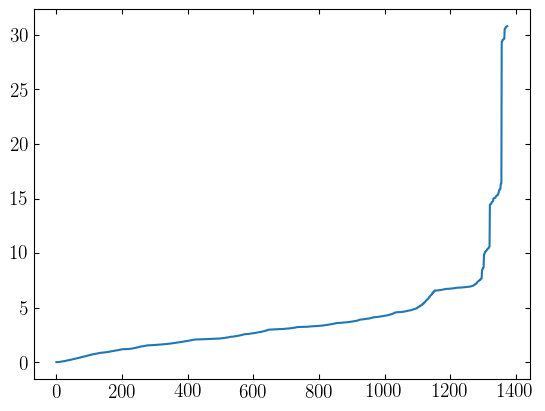

In [55]:
plt.plot(omega)
